In [1]:
import pywt
import re
import numpy as np
import matplotlib.pyplot as plt
import math
import  os
import scipy.io as sio
import time
from numpy import loadtxt
from sklearn.preprocessing import MinMaxScaler
from collections import Counter

In [2]:
data_path = r'data\centrifugal pump'##原始数据地址
save_path=r'nonoise_data'

In [3]:
def make_kernel(f):
    kernel = np.zeros((1, 2*f+1), np.float32)
    #print(kernel.shape)
    for d in range(1, f+1):
        for i in range(-d,d):
            kernel[0][f-i] += (1.0/((2*d+1)**2))
    return kernel/f

In [4]:
def nlm_1D_filter(src, f, t, h):
    #m = len(src[0])
    m = len(src) #测试用
    #out = np.zeros((1, m), np.float32)
    out=np.zeros((m),np.float32)
    # print(out)
    # memory for output

    # Replicate the boundaries of the input
    #src_padding = np.pad(src[0], (0, f), mode='symmetric').astype(np.float32)
    src_padding = np.pad(src, (0, f), mode='symmetric').astype(np.float32) #测试用
    # used kernel
    kernel = make_kernel(f)
    kernel = kernel / kernel.sum()

    for i in range(1, m):

        i1 = i + f

        if (i1 + f + 1) > src_padding.shape[0]:
            continue

        W1 = src_padding[i1 - f:i1 + f + 1]  # 领域窗口W1
        w_max = 0
        aver = 0
        weight_sum = 0
        rmin = max(i1 - t, f + 1);
        rmax = min(i1 + t, m + f);

        # 搜索窗口

        for r in range(rmin, rmax):
            if r == i1:
                continue
            elif (r + f + 1) > src_padding.shape[0]:
                continue
            else:
                W2 = src_padding[r - f:r + f + 1]  # 搜索区域内的相似窗口

                w0 = W2 - W1
                wc = np.dot(w0, w0)
                Dist2 = np.dot(kernel, wc).sum()
                w = np.exp(-Dist2 / h ** 2)
                if w > w_max:
                    w_max = w
                weight_sum = weight_sum + w
                aver = aver + w * src_padding[r]

        aver = aver + w_max * src_padding[i1]  # 自身领域取最大的权重
        weight_sum = weight_sum + w_max
        out[ i] = aver / weight_sum

    return out

# 单个数据

Running time: 0.29607462882995605 Seconds


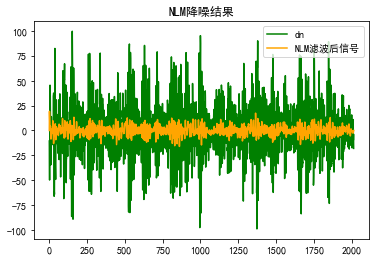

In [5]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
    
path1=os.path.join(data_path,r'bearing_failure',r'data_000001.txt')
data1=loadtxt(path1)
start=time.time()
nonoise_data= nlm_1D_filter(data1,2,5,500)
end = time.time()
print('Running time: %s Seconds' % (end - start))
plt.title('NLM降噪结果')

plt.plot(data1,color='green', label='dn')
plt.plot(nonoise_data, color='orange',label='NLM滤波后信号')

plt.legend(loc=1) # 显示图例
plt.show()

Running time: 0.3621253967285156 Seconds


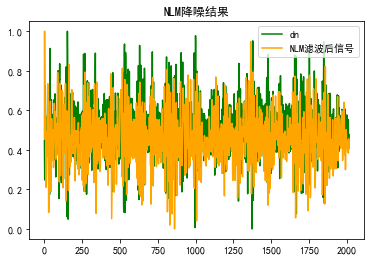

In [6]:
#加入归一化，优化图形
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
    
path1=os.path.join(data_path,r'bearing_failure',r'data_000001.txt')
data1=loadtxt(path1)

scaler = MinMaxScaler()
data2=data1.reshape(-1,1)
data2 = scaler.fit_transform(data2)
start=time.time()
nonoise_data= nlm_1D_filter(data1,2,5,500)
nonoise_data = scaler.fit_transform(nonoise_data.reshape(-1,1))
end = time.time()
print('Running time: %s Seconds' % (end - start))

plt.title('NLM降噪结果')

plt.plot(data2,color='green', label='dn')
plt.plot(nonoise_data, color='orange',label='NLM滤波后信号')

plt.legend(loc=1) # 显示图例
plt.show()

# 批量处理

In [14]:
# def data_load(path):
#     """
#     path：数据地址
#     data_name：数据名称
#     label:数据标签
#     """
#     data = loadtxt(path)
#     # 数据归一化
#     # 归一化data
#     data= nlm_1D_filter(data,2,5,500)
#     scaler = MinMaxScaler()
#     data_n = scaler.fit_transform(data)
#     data_cut = []
#     data_cut.append(data_n)
#     return data_cut    #归一化

In [16]:
#不归一化
def data_load(path):
    """
    path：数据地址
    data_name：数据名称
    label:数据标签
    """
    data = loadtxt(path)
    # 数据归一化
    # 归一化data
    data= nlm_1D_filter(data,2,5,500)
    data_cut = []
    data_cut.append(data)
    return data_cut    

In [17]:
label=[]
data_train=[]
file_1=os.listdir(data_path)
d = 0
start=time.time()
for k in file_1:
        d_path=os.path.join(data_path, k)
        filenames = os.listdir(d_path)
        for i in filenames:
            data_set = os.path.join(d_path ,i)
            data1=data_load(data_set)
            print(str(k),d,str(i))
            label.append(d)
            data_train=data_train+data1
            print(str(d_path),str(k),np.asarray(data_train,dtype = 'float').shape)
        d=d+1
end = time.time()

bearing_failure 0 data_000001.txt
data\centrifugal pump\bearing_failure bearing_failure (1, 2015)
bearing_failure 0 data_000002.txt
data\centrifugal pump\bearing_failure bearing_failure (2, 2015)
bearing_failure 0 data_000003.txt
data\centrifugal pump\bearing_failure bearing_failure (3, 2015)
bearing_failure 0 data_000004.txt
data\centrifugal pump\bearing_failure bearing_failure (4, 2015)
bearing_failure 0 data_000005.txt
data\centrifugal pump\bearing_failure bearing_failure (5, 2015)
bearing_failure 0 data_000006.txt
data\centrifugal pump\bearing_failure bearing_failure (6, 2015)
bearing_failure 0 data_000007.txt
data\centrifugal pump\bearing_failure bearing_failure (7, 2015)
bearing_failure 0 data_000008.txt
data\centrifugal pump\bearing_failure bearing_failure (8, 2015)
bearing_failure 0 data_000009.txt
data\centrifugal pump\bearing_failure bearing_failure (9, 2015)
bearing_failure 0 data_000010.txt
data\centrifugal pump\bearing_failure bearing_failure (10, 2015)
bearing_failure 0 d

bearing_failure 0 data_000084.txt
data\centrifugal pump\bearing_failure bearing_failure (84, 2015)
bearing_failure 0 data_000085.txt
data\centrifugal pump\bearing_failure bearing_failure (85, 2015)
bearing_failure 0 data_000086.txt
data\centrifugal pump\bearing_failure bearing_failure (86, 2015)
bearing_failure 0 data_000087.txt
data\centrifugal pump\bearing_failure bearing_failure (87, 2015)
bearing_failure 0 data_000088.txt
data\centrifugal pump\bearing_failure bearing_failure (88, 2015)
bearing_failure 0 data_000089.txt
data\centrifugal pump\bearing_failure bearing_failure (89, 2015)
bearing_failure 0 data_000090.txt
data\centrifugal pump\bearing_failure bearing_failure (90, 2015)
bearing_failure 0 data_000091.txt
data\centrifugal pump\bearing_failure bearing_failure (91, 2015)
bearing_failure 0 data_000092.txt
data\centrifugal pump\bearing_failure bearing_failure (92, 2015)
bearing_failure 0 data_000093.txt
data\centrifugal pump\bearing_failure bearing_failure (93, 2015)
bearing_fa

bearing_failure 0 data_000167.txt
data\centrifugal pump\bearing_failure bearing_failure (167, 2015)
bearing_failure 0 data_000168.txt
data\centrifugal pump\bearing_failure bearing_failure (168, 2015)
bearing_failure 0 data_000169.txt
data\centrifugal pump\bearing_failure bearing_failure (169, 2015)
bearing_failure 0 data_000170.txt
data\centrifugal pump\bearing_failure bearing_failure (170, 2015)
bearing_failure 0 data_000171.txt
data\centrifugal pump\bearing_failure bearing_failure (171, 2015)
bearing_failure 0 data_000172.txt
data\centrifugal pump\bearing_failure bearing_failure (172, 2015)
bearing_failure 0 data_000173.txt
data\centrifugal pump\bearing_failure bearing_failure (173, 2015)
bearing_failure 0 data_000174.txt
data\centrifugal pump\bearing_failure bearing_failure (174, 2015)
bearing_failure 0 data_000175.txt
data\centrifugal pump\bearing_failure bearing_failure (175, 2015)
bearing_failure 0 data_000176.txt
data\centrifugal pump\bearing_failure bearing_failure (176, 2015)


bearing_failure 0 data_000249.txt
data\centrifugal pump\bearing_failure bearing_failure (249, 2015)
bearing_failure 0 data_000250.txt
data\centrifugal pump\bearing_failure bearing_failure (250, 2015)
bearing_failure 0 data_000251.txt
data\centrifugal pump\bearing_failure bearing_failure (251, 2015)
bearing_failure 0 data_000252.txt
data\centrifugal pump\bearing_failure bearing_failure (252, 2015)
bearing_failure 0 data_000253.txt
data\centrifugal pump\bearing_failure bearing_failure (253, 2015)
bearing_failure 0 data_000254.txt
data\centrifugal pump\bearing_failure bearing_failure (254, 2015)
bearing_failure 0 data_000255.txt
data\centrifugal pump\bearing_failure bearing_failure (255, 2015)
bearing_failure 0 data_000256.txt
data\centrifugal pump\bearing_failure bearing_failure (256, 2015)
bearing_failure 0 data_000257.txt
data\centrifugal pump\bearing_failure bearing_failure (257, 2015)
bearing_failure 0 data_000258.txt
data\centrifugal pump\bearing_failure bearing_failure (258, 2015)


bearing_failure 0 data_000331.txt
data\centrifugal pump\bearing_failure bearing_failure (331, 2015)
bearing_failure 0 data_000332.txt
data\centrifugal pump\bearing_failure bearing_failure (332, 2015)
bearing_failure 0 data_000333.txt
data\centrifugal pump\bearing_failure bearing_failure (333, 2015)
bearing_failure 0 data_000334.txt
data\centrifugal pump\bearing_failure bearing_failure (334, 2015)
bearing_failure 0 data_000335.txt
data\centrifugal pump\bearing_failure bearing_failure (335, 2015)
bearing_failure 0 data_000336.txt
data\centrifugal pump\bearing_failure bearing_failure (336, 2015)
bearing_failure 0 data_000337.txt
data\centrifugal pump\bearing_failure bearing_failure (337, 2015)
bearing_failure 0 data_000338.txt
data\centrifugal pump\bearing_failure bearing_failure (338, 2015)
bearing_failure 0 data_000339.txt
data\centrifugal pump\bearing_failure bearing_failure (339, 2015)
bearing_failure 0 data_000340.txt
data\centrifugal pump\bearing_failure bearing_failure (340, 2015)


bearing_failure 0 data_000413.txt
data\centrifugal pump\bearing_failure bearing_failure (413, 2015)
bearing_failure 0 data_000414.txt
data\centrifugal pump\bearing_failure bearing_failure (414, 2015)
bearing_failure 0 data_000415.txt
data\centrifugal pump\bearing_failure bearing_failure (415, 2015)
bearing_failure 0 data_000416.txt
data\centrifugal pump\bearing_failure bearing_failure (416, 2015)
bearing_failure 0 data_000417.txt
data\centrifugal pump\bearing_failure bearing_failure (417, 2015)
bearing_failure 0 data_000418.txt
data\centrifugal pump\bearing_failure bearing_failure (418, 2015)
bearing_failure 0 data_000419.txt
data\centrifugal pump\bearing_failure bearing_failure (419, 2015)
bearing_failure 0 data_000420.txt
data\centrifugal pump\bearing_failure bearing_failure (420, 2015)
bearing_failure 0 data_000421.txt
data\centrifugal pump\bearing_failure bearing_failure (421, 2015)
bearing_failure 0 data_000422.txt
data\centrifugal pump\bearing_failure bearing_failure (422, 2015)


bearing_failure 0 data_000495.txt
data\centrifugal pump\bearing_failure bearing_failure (495, 2015)
bearing_failure 0 data_000496.txt
data\centrifugal pump\bearing_failure bearing_failure (496, 2015)
bearing_failure 0 data_000497.txt
data\centrifugal pump\bearing_failure bearing_failure (497, 2015)
bearing_failure 0 data_000498.txt
data\centrifugal pump\bearing_failure bearing_failure (498, 2015)
bearing_failure 0 data_000499.txt
data\centrifugal pump\bearing_failure bearing_failure (499, 2015)
bearing_failure 0 data_000500.txt
data\centrifugal pump\bearing_failure bearing_failure (500, 2015)
bearing_failure 0 data_000501.txt
data\centrifugal pump\bearing_failure bearing_failure (501, 2015)
bearing_failure 0 data_000502.txt
data\centrifugal pump\bearing_failure bearing_failure (502, 2015)
bearing_failure 0 data_000503.txt
data\centrifugal pump\bearing_failure bearing_failure (503, 2015)
bearing_failure 0 data_000504.txt
data\centrifugal pump\bearing_failure bearing_failure (504, 2015)


bearing_failure 0 data_000577.txt
data\centrifugal pump\bearing_failure bearing_failure (577, 2015)
bearing_failure 0 data_000578.txt
data\centrifugal pump\bearing_failure bearing_failure (578, 2015)
bearing_failure 0 data_000579.txt
data\centrifugal pump\bearing_failure bearing_failure (579, 2015)
bearing_failure 0 data_000580.txt
data\centrifugal pump\bearing_failure bearing_failure (580, 2015)
bearing_failure 0 data_000581.txt
data\centrifugal pump\bearing_failure bearing_failure (581, 2015)
bearing_failure 0 data_000582.txt
data\centrifugal pump\bearing_failure bearing_failure (582, 2015)
bearing_failure 0 data_000583.txt
data\centrifugal pump\bearing_failure bearing_failure (583, 2015)
bearing_failure 0 data_000584.txt
data\centrifugal pump\bearing_failure bearing_failure (584, 2015)
bearing_failure 0 data_000585.txt
data\centrifugal pump\bearing_failure bearing_failure (585, 2015)
bearing_failure 0 data_000586.txt
data\centrifugal pump\bearing_failure bearing_failure (586, 2015)


bearing_failure 0 data_000659.txt
data\centrifugal pump\bearing_failure bearing_failure (659, 2015)
bearing_failure 0 data_000660.txt
data\centrifugal pump\bearing_failure bearing_failure (660, 2015)
bearing_failure 0 data_000661.txt
data\centrifugal pump\bearing_failure bearing_failure (661, 2015)
bearing_failure 0 data_000662.txt
data\centrifugal pump\bearing_failure bearing_failure (662, 2015)
bearing_failure 0 data_000663.txt
data\centrifugal pump\bearing_failure bearing_failure (663, 2015)
bearing_failure 0 data_000664.txt
data\centrifugal pump\bearing_failure bearing_failure (664, 2015)
bearing_failure 0 data_000665.txt
data\centrifugal pump\bearing_failure bearing_failure (665, 2015)
bearing_failure 0 data_000666.txt
data\centrifugal pump\bearing_failure bearing_failure (666, 2015)
bearing_failure 0 data_000667.txt
data\centrifugal pump\bearing_failure bearing_failure (667, 2015)
bearing_failure 0 data_000668.txt
data\centrifugal pump\bearing_failure bearing_failure (668, 2015)


bearing_failure 0 data_000741.txt
data\centrifugal pump\bearing_failure bearing_failure (741, 2015)
bearing_failure 0 data_000742.txt
data\centrifugal pump\bearing_failure bearing_failure (742, 2015)
bearing_failure 0 data_000743.txt
data\centrifugal pump\bearing_failure bearing_failure (743, 2015)
bearing_failure 0 data_000744.txt
data\centrifugal pump\bearing_failure bearing_failure (744, 2015)
bearing_failure 0 data_000745.txt
data\centrifugal pump\bearing_failure bearing_failure (745, 2015)
bearing_failure 0 data_000746.txt
data\centrifugal pump\bearing_failure bearing_failure (746, 2015)
bearing_failure 0 data_000747.txt
data\centrifugal pump\bearing_failure bearing_failure (747, 2015)
bearing_failure 0 data_000748.txt
data\centrifugal pump\bearing_failure bearing_failure (748, 2015)
bearing_failure 0 data_000749.txt
data\centrifugal pump\bearing_failure bearing_failure (749, 2015)
bearing_failure 0 data_000750.txt
data\centrifugal pump\bearing_failure bearing_failure (750, 2015)


bearing_failure 0 data_000823.txt
data\centrifugal pump\bearing_failure bearing_failure (823, 2015)
bearing_failure 0 data_000824.txt
data\centrifugal pump\bearing_failure bearing_failure (824, 2015)
bearing_failure 0 data_000825.txt
data\centrifugal pump\bearing_failure bearing_failure (825, 2015)
bearing_failure 0 data_000826.txt
data\centrifugal pump\bearing_failure bearing_failure (826, 2015)
bearing_failure 0 data_000827.txt
data\centrifugal pump\bearing_failure bearing_failure (827, 2015)
bearing_failure 0 data_000828.txt
data\centrifugal pump\bearing_failure bearing_failure (828, 2015)
bearing_failure 0 data_000829.txt
data\centrifugal pump\bearing_failure bearing_failure (829, 2015)
bearing_failure 0 data_000830.txt
data\centrifugal pump\bearing_failure bearing_failure (830, 2015)
bearing_failure 0 data_000831.txt
data\centrifugal pump\bearing_failure bearing_failure (831, 2015)
bearing_failure 0 data_000832.txt
data\centrifugal pump\bearing_failure bearing_failure (832, 2015)


bearing_failure 0 data_000905.txt
data\centrifugal pump\bearing_failure bearing_failure (905, 2015)
bearing_failure 0 data_000906.txt
data\centrifugal pump\bearing_failure bearing_failure (906, 2015)
bearing_failure 0 data_000907.txt
data\centrifugal pump\bearing_failure bearing_failure (907, 2015)
bearing_failure 0 data_000908.txt
data\centrifugal pump\bearing_failure bearing_failure (908, 2015)
bearing_failure 0 data_000909.txt
data\centrifugal pump\bearing_failure bearing_failure (909, 2015)
bearing_failure 0 data_000910.txt
data\centrifugal pump\bearing_failure bearing_failure (910, 2015)
bearing_failure 0 data_000911.txt
data\centrifugal pump\bearing_failure bearing_failure (911, 2015)
bearing_failure 0 data_000912.txt
data\centrifugal pump\bearing_failure bearing_failure (912, 2015)
bearing_failure 0 data_000913.txt
data\centrifugal pump\bearing_failure bearing_failure (913, 2015)
bearing_failure 0 data_000914.txt
data\centrifugal pump\bearing_failure bearing_failure (914, 2015)


bearing_failure 0 data_000987.txt
data\centrifugal pump\bearing_failure bearing_failure (987, 2015)
bearing_failure 0 data_000988.txt
data\centrifugal pump\bearing_failure bearing_failure (988, 2015)
bearing_failure 0 data_000989.txt
data\centrifugal pump\bearing_failure bearing_failure (989, 2015)
bearing_failure 0 data_000990.txt
data\centrifugal pump\bearing_failure bearing_failure (990, 2015)
bearing_failure 0 data_000991.txt
data\centrifugal pump\bearing_failure bearing_failure (991, 2015)
bearing_failure 0 data_000992.txt
data\centrifugal pump\bearing_failure bearing_failure (992, 2015)
bearing_failure 0 data_000993.txt
data\centrifugal pump\bearing_failure bearing_failure (993, 2015)
bearing_failure 0 data_000994.txt
data\centrifugal pump\bearing_failure bearing_failure (994, 2015)
bearing_failure 0 data_000995.txt
data\centrifugal pump\bearing_failure bearing_failure (995, 2015)
bearing_failure 0 data_000996.txt
data\centrifugal pump\bearing_failure bearing_failure (996, 2015)


bearing_failure 0 data_001069.txt
data\centrifugal pump\bearing_failure bearing_failure (1069, 2015)
bearing_failure 0 data_001070.txt
data\centrifugal pump\bearing_failure bearing_failure (1070, 2015)
bearing_failure 0 data_001071.txt
data\centrifugal pump\bearing_failure bearing_failure (1071, 2015)
bearing_failure 0 data_001072.txt
data\centrifugal pump\bearing_failure bearing_failure (1072, 2015)
bearing_failure 0 data_001073.txt
data\centrifugal pump\bearing_failure bearing_failure (1073, 2015)
bearing_failure 0 data_001074.txt
data\centrifugal pump\bearing_failure bearing_failure (1074, 2015)
bearing_failure 0 data_001075.txt
data\centrifugal pump\bearing_failure bearing_failure (1075, 2015)
bearing_failure 0 data_001076.txt
data\centrifugal pump\bearing_failure bearing_failure (1076, 2015)
bearing_failure 0 data_001077.txt
data\centrifugal pump\bearing_failure bearing_failure (1077, 2015)
bearing_failure 0 data_001078.txt
data\centrifugal pump\bearing_failure bearing_failure (10

bearing_failure 0 data_001151.txt
data\centrifugal pump\bearing_failure bearing_failure (1151, 2015)
bearing_failure 0 data_001152.txt
data\centrifugal pump\bearing_failure bearing_failure (1152, 2015)
bearing_failure 0 data_001153.txt
data\centrifugal pump\bearing_failure bearing_failure (1153, 2015)
bearing_failure 0 data_001154.txt
data\centrifugal pump\bearing_failure bearing_failure (1154, 2015)
bearing_failure 0 data_001155.txt
data\centrifugal pump\bearing_failure bearing_failure (1155, 2015)
bearing_failure 0 data_001156.txt
data\centrifugal pump\bearing_failure bearing_failure (1156, 2015)
bearing_failure 0 data_001157.txt
data\centrifugal pump\bearing_failure bearing_failure (1157, 2015)
bearing_failure 0 data_001158.txt
data\centrifugal pump\bearing_failure bearing_failure (1158, 2015)
bearing_failure 0 data_001159.txt
data\centrifugal pump\bearing_failure bearing_failure (1159, 2015)
bearing_failure 0 data_001160.txt
data\centrifugal pump\bearing_failure bearing_failure (11

imbalance 1 data_000064.txt
data\centrifugal pump\imbalance imbalance (1244, 2015)
imbalance 1 data_000065.txt
data\centrifugal pump\imbalance imbalance (1245, 2015)
imbalance 1 data_000066.txt
data\centrifugal pump\imbalance imbalance (1246, 2015)
imbalance 1 data_000067.txt
data\centrifugal pump\imbalance imbalance (1247, 2015)
imbalance 1 data_000068.txt
data\centrifugal pump\imbalance imbalance (1248, 2015)
imbalance 1 data_000069.txt
data\centrifugal pump\imbalance imbalance (1249, 2015)
imbalance 1 data_000070.txt
data\centrifugal pump\imbalance imbalance (1250, 2015)
imbalance 1 data_000071.txt
data\centrifugal pump\imbalance imbalance (1251, 2015)
imbalance 1 data_000072.txt
data\centrifugal pump\imbalance imbalance (1252, 2015)
imbalance 1 data_000073.txt
data\centrifugal pump\imbalance imbalance (1253, 2015)
imbalance 1 data_000074.txt
data\centrifugal pump\imbalance imbalance (1254, 2015)
imbalance 1 data_000075.txt
data\centrifugal pump\imbalance imbalance (1255, 2015)
imba

imbalance 1 data_000163.txt
data\centrifugal pump\imbalance imbalance (1343, 2015)
imbalance 1 data_000164.txt
data\centrifugal pump\imbalance imbalance (1344, 2015)
imbalance 1 data_000165.txt
data\centrifugal pump\imbalance imbalance (1345, 2015)
imbalance 1 data_000166.txt
data\centrifugal pump\imbalance imbalance (1346, 2015)
imbalance 1 data_000167.txt
data\centrifugal pump\imbalance imbalance (1347, 2015)
imbalance 1 data_000168.txt
data\centrifugal pump\imbalance imbalance (1348, 2015)
imbalance 1 data_000169.txt
data\centrifugal pump\imbalance imbalance (1349, 2015)
imbalance 1 data_000170.txt
data\centrifugal pump\imbalance imbalance (1350, 2015)
imbalance 1 data_000171.txt
data\centrifugal pump\imbalance imbalance (1351, 2015)
imbalance 1 data_000172.txt
data\centrifugal pump\imbalance imbalance (1352, 2015)
imbalance 1 data_000173.txt
data\centrifugal pump\imbalance imbalance (1353, 2015)
imbalance 1 data_000174.txt
data\centrifugal pump\imbalance imbalance (1354, 2015)
imba

imbalance 1 data_000262.txt
data\centrifugal pump\imbalance imbalance (1442, 2015)
imbalance 1 data_000263.txt
data\centrifugal pump\imbalance imbalance (1443, 2015)
imbalance 1 data_000264.txt
data\centrifugal pump\imbalance imbalance (1444, 2015)
imbalance 1 data_000265.txt
data\centrifugal pump\imbalance imbalance (1445, 2015)
imbalance 1 data_000266.txt
data\centrifugal pump\imbalance imbalance (1446, 2015)
imbalance 1 data_000267.txt
data\centrifugal pump\imbalance imbalance (1447, 2015)
imbalance 1 data_000268.txt
data\centrifugal pump\imbalance imbalance (1448, 2015)
imbalance 1 data_000269.txt
data\centrifugal pump\imbalance imbalance (1449, 2015)
imbalance 1 data_000270.txt
data\centrifugal pump\imbalance imbalance (1450, 2015)
imbalance 1 data_000271.txt
data\centrifugal pump\imbalance imbalance (1451, 2015)
imbalance 1 data_000272.txt
data\centrifugal pump\imbalance imbalance (1452, 2015)
imbalance 1 data_000273.txt
data\centrifugal pump\imbalance imbalance (1453, 2015)
imba

imbalance 1 data_000361.txt
data\centrifugal pump\imbalance imbalance (1541, 2015)
imbalance 1 data_000362.txt
data\centrifugal pump\imbalance imbalance (1542, 2015)
imbalance 1 data_000363.txt
data\centrifugal pump\imbalance imbalance (1543, 2015)
imbalance 1 data_000364.txt
data\centrifugal pump\imbalance imbalance (1544, 2015)
imbalance 1 data_000365.txt
data\centrifugal pump\imbalance imbalance (1545, 2015)
imbalance 1 data_000366.txt
data\centrifugal pump\imbalance imbalance (1546, 2015)
imbalance 1 data_000367.txt
data\centrifugal pump\imbalance imbalance (1547, 2015)
imbalance 1 data_000368.txt
data\centrifugal pump\imbalance imbalance (1548, 2015)
imbalance 1 data_000369.txt
data\centrifugal pump\imbalance imbalance (1549, 2015)
imbalance 1 data_000370.txt
data\centrifugal pump\imbalance imbalance (1550, 2015)
imbalance 1 data_000371.txt
data\centrifugal pump\imbalance imbalance (1551, 2015)
imbalance 1 data_000372.txt
data\centrifugal pump\imbalance imbalance (1552, 2015)
imba

imbalance 1 data_000460.txt
data\centrifugal pump\imbalance imbalance (1640, 2015)
imbalance 1 data_000461.txt
data\centrifugal pump\imbalance imbalance (1641, 2015)
imbalance 1 data_000462.txt
data\centrifugal pump\imbalance imbalance (1642, 2015)
imbalance 1 data_000463.txt
data\centrifugal pump\imbalance imbalance (1643, 2015)
imbalance 1 data_000464.txt
data\centrifugal pump\imbalance imbalance (1644, 2015)
imbalance 1 data_000465.txt
data\centrifugal pump\imbalance imbalance (1645, 2015)
imbalance 1 data_000466.txt
data\centrifugal pump\imbalance imbalance (1646, 2015)
imbalance 1 data_000467.txt
data\centrifugal pump\imbalance imbalance (1647, 2015)
imbalance 1 data_000468.txt
data\centrifugal pump\imbalance imbalance (1648, 2015)
imbalance 1 data_000469.txt
data\centrifugal pump\imbalance imbalance (1649, 2015)
imbalance 1 data_000470.txt
data\centrifugal pump\imbalance imbalance (1650, 2015)
imbalance 1 data_000471.txt
data\centrifugal pump\imbalance imbalance (1651, 2015)
imba

imbalance 1 data_000559.txt
data\centrifugal pump\imbalance imbalance (1739, 2015)
imbalance 1 data_000560.txt
data\centrifugal pump\imbalance imbalance (1740, 2015)
imbalance 1 data_000561.txt
data\centrifugal pump\imbalance imbalance (1741, 2015)
imbalance 1 data_000562.txt
data\centrifugal pump\imbalance imbalance (1742, 2015)
imbalance 1 data_000563.txt
data\centrifugal pump\imbalance imbalance (1743, 2015)
imbalance 1 data_000564.txt
data\centrifugal pump\imbalance imbalance (1744, 2015)
imbalance 1 data_000565.txt
data\centrifugal pump\imbalance imbalance (1745, 2015)
imbalance 1 data_000566.txt
data\centrifugal pump\imbalance imbalance (1746, 2015)
imbalance 1 data_000567.txt
data\centrifugal pump\imbalance imbalance (1747, 2015)
imbalance 1 data_000568.txt
data\centrifugal pump\imbalance imbalance (1748, 2015)
imbalance 1 data_000569.txt
data\centrifugal pump\imbalance imbalance (1749, 2015)
imbalance 1 data_000570.txt
data\centrifugal pump\imbalance imbalance (1750, 2015)
imba

imbalance 1 data_000658.txt
data\centrifugal pump\imbalance imbalance (1838, 2015)
imbalance 1 data_000659.txt
data\centrifugal pump\imbalance imbalance (1839, 2015)
imbalance 1 data_000660.txt
data\centrifugal pump\imbalance imbalance (1840, 2015)
imbalance 1 data_000661.txt
data\centrifugal pump\imbalance imbalance (1841, 2015)
imbalance 1 data_000662.txt
data\centrifugal pump\imbalance imbalance (1842, 2015)
imbalance 1 data_000663.txt
data\centrifugal pump\imbalance imbalance (1843, 2015)
imbalance 1 data_000664.txt
data\centrifugal pump\imbalance imbalance (1844, 2015)
imbalance 1 data_000665.txt
data\centrifugal pump\imbalance imbalance (1845, 2015)
imbalance 1 data_000666.txt
data\centrifugal pump\imbalance imbalance (1846, 2015)
imbalance 1 data_000667.txt
data\centrifugal pump\imbalance imbalance (1847, 2015)
imbalance 1 data_000668.txt
data\centrifugal pump\imbalance imbalance (1848, 2015)
imbalance 1 data_000669.txt
data\centrifugal pump\imbalance imbalance (1849, 2015)
imba

imbalance 1 data_000757.txt
data\centrifugal pump\imbalance imbalance (1937, 2015)
imbalance 1 data_000758.txt
data\centrifugal pump\imbalance imbalance (1938, 2015)
imbalance 1 data_000759.txt
data\centrifugal pump\imbalance imbalance (1939, 2015)
imbalance 1 data_000760.txt
data\centrifugal pump\imbalance imbalance (1940, 2015)
imbalance 1 data_000761.txt
data\centrifugal pump\imbalance imbalance (1941, 2015)
imbalance 1 data_000762.txt
data\centrifugal pump\imbalance imbalance (1942, 2015)
imbalance 1 data_000763.txt
data\centrifugal pump\imbalance imbalance (1943, 2015)
imbalance 1 data_000764.txt
data\centrifugal pump\imbalance imbalance (1944, 2015)
imbalance 1 data_000765.txt
data\centrifugal pump\imbalance imbalance (1945, 2015)
imbalance 1 data_000766.txt
data\centrifugal pump\imbalance imbalance (1946, 2015)
imbalance 1 data_000767.txt
data\centrifugal pump\imbalance imbalance (1947, 2015)
imbalance 1 data_000768.txt
data\centrifugal pump\imbalance imbalance (1948, 2015)
imba

imbalance 1 data_000856.txt
data\centrifugal pump\imbalance imbalance (2036, 2015)
imbalance 1 data_000857.txt
data\centrifugal pump\imbalance imbalance (2037, 2015)
imbalance 1 data_000858.txt
data\centrifugal pump\imbalance imbalance (2038, 2015)
imbalance 1 data_000859.txt
data\centrifugal pump\imbalance imbalance (2039, 2015)
imbalance 1 data_000860.txt
data\centrifugal pump\imbalance imbalance (2040, 2015)
imbalance 1 data_000861.txt
data\centrifugal pump\imbalance imbalance (2041, 2015)
imbalance 1 data_000862.txt
data\centrifugal pump\imbalance imbalance (2042, 2015)
imbalance 1 data_000863.txt
data\centrifugal pump\imbalance imbalance (2043, 2015)
imbalance 1 data_000864.txt
data\centrifugal pump\imbalance imbalance (2044, 2015)
imbalance 1 data_000865.txt
data\centrifugal pump\imbalance imbalance (2045, 2015)
imbalance 1 data_000866.txt
data\centrifugal pump\imbalance imbalance (2046, 2015)
imbalance 1 data_000867.txt
data\centrifugal pump\imbalance imbalance (2047, 2015)
imba

imbalance 1 data_000955.txt
data\centrifugal pump\imbalance imbalance (2135, 2015)
imbalance 1 data_000956.txt
data\centrifugal pump\imbalance imbalance (2136, 2015)
imbalance 1 data_000957.txt
data\centrifugal pump\imbalance imbalance (2137, 2015)
imbalance 1 data_000958.txt
data\centrifugal pump\imbalance imbalance (2138, 2015)
imbalance 1 data_000959.txt
data\centrifugal pump\imbalance imbalance (2139, 2015)
imbalance 1 data_000960.txt
data\centrifugal pump\imbalance imbalance (2140, 2015)
imbalance 1 data_000961.txt
data\centrifugal pump\imbalance imbalance (2141, 2015)
imbalance 1 data_000962.txt
data\centrifugal pump\imbalance imbalance (2142, 2015)
imbalance 1 data_000963.txt
data\centrifugal pump\imbalance imbalance (2143, 2015)
imbalance 1 data_000964.txt
data\centrifugal pump\imbalance imbalance (2144, 2015)
imbalance 1 data_000965.txt
data\centrifugal pump\imbalance imbalance (2145, 2015)
imbalance 1 data_000966.txt
data\centrifugal pump\imbalance imbalance (2146, 2015)
imba

imbalance 1 data_001054.txt
data\centrifugal pump\imbalance imbalance (2234, 2015)
imbalance 1 data_001055.txt
data\centrifugal pump\imbalance imbalance (2235, 2015)
imbalance 1 data_001056.txt
data\centrifugal pump\imbalance imbalance (2236, 2015)
imbalance 1 data_001057.txt
data\centrifugal pump\imbalance imbalance (2237, 2015)
imbalance 1 data_001058.txt
data\centrifugal pump\imbalance imbalance (2238, 2015)
imbalance 1 data_001059.txt
data\centrifugal pump\imbalance imbalance (2239, 2015)
imbalance 1 data_001060.txt
data\centrifugal pump\imbalance imbalance (2240, 2015)
imbalance 1 data_001061.txt
data\centrifugal pump\imbalance imbalance (2241, 2015)
imbalance 1 data_001062.txt
data\centrifugal pump\imbalance imbalance (2242, 2015)
imbalance 1 data_001063.txt
data\centrifugal pump\imbalance imbalance (2243, 2015)
imbalance 1 data_001064.txt
data\centrifugal pump\imbalance imbalance (2244, 2015)
imbalance 1 data_001065.txt
data\centrifugal pump\imbalance imbalance (2245, 2015)
imba

imbalance 1 data_001153.txt
data\centrifugal pump\imbalance imbalance (2333, 2015)
imbalance 1 data_001154.txt
data\centrifugal pump\imbalance imbalance (2334, 2015)
imbalance 1 data_001155.txt
data\centrifugal pump\imbalance imbalance (2335, 2015)
imbalance 1 data_001156.txt
data\centrifugal pump\imbalance imbalance (2336, 2015)
imbalance 1 data_001157.txt
data\centrifugal pump\imbalance imbalance (2337, 2015)
imbalance 1 data_001158.txt
data\centrifugal pump\imbalance imbalance (2338, 2015)
imbalance 1 data_001159.txt
data\centrifugal pump\imbalance imbalance (2339, 2015)
imbalance 1 data_001160.txt
data\centrifugal pump\imbalance imbalance (2340, 2015)
imbalance 1 data_001161.txt
data\centrifugal pump\imbalance imbalance (2341, 2015)
imbalance 1 data_001162.txt
data\centrifugal pump\imbalance imbalance (2342, 2015)
imbalance 1 data_001163.txt
data\centrifugal pump\imbalance imbalance (2343, 2015)
imbalance 1 data_001164.txt
data\centrifugal pump\imbalance imbalance (2344, 2015)
imba

normal 2 data_000018.txt
data\centrifugal pump\normal normal (2434, 2015)
normal 2 data_000019.txt
data\centrifugal pump\normal normal (2435, 2015)
normal 2 data_000020.txt
data\centrifugal pump\normal normal (2436, 2015)
normal 2 data_000021.txt
data\centrifugal pump\normal normal (2437, 2015)
normal 2 data_000022.txt
data\centrifugal pump\normal normal (2438, 2015)
normal 2 data_000023.txt
data\centrifugal pump\normal normal (2439, 2015)
normal 2 data_000024.txt
data\centrifugal pump\normal normal (2440, 2015)
normal 2 data_000025.txt
data\centrifugal pump\normal normal (2441, 2015)
normal 2 data_000026.txt
data\centrifugal pump\normal normal (2442, 2015)
normal 2 data_000027.txt
data\centrifugal pump\normal normal (2443, 2015)
normal 2 data_000028.txt
data\centrifugal pump\normal normal (2444, 2015)
normal 2 data_000029.txt
data\centrifugal pump\normal normal (2445, 2015)
normal 2 data_000030.txt
data\centrifugal pump\normal normal (2446, 2015)
normal 2 data_000031.txt
data\centrifu

normal 2 data_000129.txt
data\centrifugal pump\normal normal (2545, 2015)
normal 2 data_000130.txt
data\centrifugal pump\normal normal (2546, 2015)
normal 2 data_000131.txt
data\centrifugal pump\normal normal (2547, 2015)
normal 2 data_000132.txt
data\centrifugal pump\normal normal (2548, 2015)
normal 2 data_000133.txt
data\centrifugal pump\normal normal (2549, 2015)
normal 2 data_000134.txt
data\centrifugal pump\normal normal (2550, 2015)
normal 2 data_000135.txt
data\centrifugal pump\normal normal (2551, 2015)
normal 2 data_000136.txt
data\centrifugal pump\normal normal (2552, 2015)
normal 2 data_000137.txt
data\centrifugal pump\normal normal (2553, 2015)
normal 2 data_000138.txt
data\centrifugal pump\normal normal (2554, 2015)
normal 2 data_000139.txt
data\centrifugal pump\normal normal (2555, 2015)
normal 2 data_000140.txt
data\centrifugal pump\normal normal (2556, 2015)
normal 2 data_000141.txt
data\centrifugal pump\normal normal (2557, 2015)
normal 2 data_000142.txt
data\centrifu

normal 2 data_000240.txt
data\centrifugal pump\normal normal (2656, 2015)
normal 2 data_000241.txt
data\centrifugal pump\normal normal (2657, 2015)
normal 2 data_000242.txt
data\centrifugal pump\normal normal (2658, 2015)
normal 2 data_000243.txt
data\centrifugal pump\normal normal (2659, 2015)
normal 2 data_000244.txt
data\centrifugal pump\normal normal (2660, 2015)
normal 2 data_000245.txt
data\centrifugal pump\normal normal (2661, 2015)
normal 2 data_000246.txt
data\centrifugal pump\normal normal (2662, 2015)
normal 2 data_000247.txt
data\centrifugal pump\normal normal (2663, 2015)
normal 2 data_000248.txt
data\centrifugal pump\normal normal (2664, 2015)
normal 2 data_000249.txt
data\centrifugal pump\normal normal (2665, 2015)
normal 2 data_000250.txt
data\centrifugal pump\normal normal (2666, 2015)
normal 2 data_000251.txt
data\centrifugal pump\normal normal (2667, 2015)
normal 2 data_000252.txt
data\centrifugal pump\normal normal (2668, 2015)
normal 2 data_000253.txt
data\centrifu

normal 2 data_000351.txt
data\centrifugal pump\normal normal (2767, 2015)
normal 2 data_000352.txt
data\centrifugal pump\normal normal (2768, 2015)
normal 2 data_000353.txt
data\centrifugal pump\normal normal (2769, 2015)
normal 2 data_000354.txt
data\centrifugal pump\normal normal (2770, 2015)
normal 2 data_000355.txt
data\centrifugal pump\normal normal (2771, 2015)
normal 2 data_000356.txt
data\centrifugal pump\normal normal (2772, 2015)
normal 2 data_000357.txt
data\centrifugal pump\normal normal (2773, 2015)
normal 2 data_000358.txt
data\centrifugal pump\normal normal (2774, 2015)
normal 2 data_000359.txt
data\centrifugal pump\normal normal (2775, 2015)
normal 2 data_000360.txt
data\centrifugal pump\normal normal (2776, 2015)
normal 2 data_000361.txt
data\centrifugal pump\normal normal (2777, 2015)
normal 2 data_000362.txt
data\centrifugal pump\normal normal (2778, 2015)
normal 2 data_000363.txt
data\centrifugal pump\normal normal (2779, 2015)
normal 2 data_000364.txt
data\centrifu

normal 2 data_000462.txt
data\centrifugal pump\normal normal (2878, 2015)
normal 2 data_000463.txt
data\centrifugal pump\normal normal (2879, 2015)
normal 2 data_000464.txt
data\centrifugal pump\normal normal (2880, 2015)
normal 2 data_000465.txt
data\centrifugal pump\normal normal (2881, 2015)
normal 2 data_000466.txt
data\centrifugal pump\normal normal (2882, 2015)
normal 2 data_000467.txt
data\centrifugal pump\normal normal (2883, 2015)
normal 2 data_000468.txt
data\centrifugal pump\normal normal (2884, 2015)
normal 2 data_000469.txt
data\centrifugal pump\normal normal (2885, 2015)
normal 2 data_000470.txt
data\centrifugal pump\normal normal (2886, 2015)
normal 2 data_000471.txt
data\centrifugal pump\normal normal (2887, 2015)
normal 2 data_000472.txt
data\centrifugal pump\normal normal (2888, 2015)
normal 2 data_000473.txt
data\centrifugal pump\normal normal (2889, 2015)
normal 2 data_000474.txt
data\centrifugal pump\normal normal (2890, 2015)
normal 2 data_000475.txt
data\centrifu

normal 2 data_000573.txt
data\centrifugal pump\normal normal (2989, 2015)
normal 2 data_000574.txt
data\centrifugal pump\normal normal (2990, 2015)
normal 2 data_000575.txt
data\centrifugal pump\normal normal (2991, 2015)
normal 2 data_000576.txt
data\centrifugal pump\normal normal (2992, 2015)
normal 2 data_000577.txt
data\centrifugal pump\normal normal (2993, 2015)
normal 2 data_000578.txt
data\centrifugal pump\normal normal (2994, 2015)
normal 2 data_000579.txt
data\centrifugal pump\normal normal (2995, 2015)
normal 2 data_000580.txt
data\centrifugal pump\normal normal (2996, 2015)
normal 2 data_000581.txt
data\centrifugal pump\normal normal (2997, 2015)
normal 2 data_000582.txt
data\centrifugal pump\normal normal (2998, 2015)
normal 2 data_000583.txt
data\centrifugal pump\normal normal (2999, 2015)
normal 2 data_000584.txt
data\centrifugal pump\normal normal (3000, 2015)
normal 2 data_000585.txt
data\centrifugal pump\normal normal (3001, 2015)
normal 2 data_000586.txt
data\centrifu

normal 2 data_000684.txt
data\centrifugal pump\normal normal (3100, 2015)
normal 2 data_000685.txt
data\centrifugal pump\normal normal (3101, 2015)
normal 2 data_000686.txt
data\centrifugal pump\normal normal (3102, 2015)
normal 2 data_000687.txt
data\centrifugal pump\normal normal (3103, 2015)
normal 2 data_000688.txt
data\centrifugal pump\normal normal (3104, 2015)
normal 2 data_000689.txt
data\centrifugal pump\normal normal (3105, 2015)
normal 2 data_000690.txt
data\centrifugal pump\normal normal (3106, 2015)
normal 2 data_000691.txt
data\centrifugal pump\normal normal (3107, 2015)
normal 2 data_000692.txt
data\centrifugal pump\normal normal (3108, 2015)
normal 2 data_000693.txt
data\centrifugal pump\normal normal (3109, 2015)
normal 2 data_000694.txt
data\centrifugal pump\normal normal (3110, 2015)
normal 2 data_000695.txt
data\centrifugal pump\normal normal (3111, 2015)
normal 2 data_000696.txt
data\centrifugal pump\normal normal (3112, 2015)
normal 2 data_000697.txt
data\centrifu

normal 2 data_000795.txt
data\centrifugal pump\normal normal (3211, 2015)
normal 2 data_000796.txt
data\centrifugal pump\normal normal (3212, 2015)
normal 2 data_000797.txt
data\centrifugal pump\normal normal (3213, 2015)
normal 2 data_000798.txt
data\centrifugal pump\normal normal (3214, 2015)
normal 2 data_000799.txt
data\centrifugal pump\normal normal (3215, 2015)
normal 2 data_000800.txt
data\centrifugal pump\normal normal (3216, 2015)
normal 2 data_000801.txt
data\centrifugal pump\normal normal (3217, 2015)
normal 2 data_000802.txt
data\centrifugal pump\normal normal (3218, 2015)
normal 2 data_000803.txt
data\centrifugal pump\normal normal (3219, 2015)
normal 2 data_000804.txt
data\centrifugal pump\normal normal (3220, 2015)
normal 2 data_000805.txt
data\centrifugal pump\normal normal (3221, 2015)
normal 2 data_000806.txt
data\centrifugal pump\normal normal (3222, 2015)
normal 2 data_000807.txt
data\centrifugal pump\normal normal (3223, 2015)
normal 2 data_000808.txt
data\centrifu

normal 2 data_000906.txt
data\centrifugal pump\normal normal (3322, 2015)
normal 2 data_000907.txt
data\centrifugal pump\normal normal (3323, 2015)
normal 2 data_000908.txt
data\centrifugal pump\normal normal (3324, 2015)
normal 2 data_000909.txt
data\centrifugal pump\normal normal (3325, 2015)
normal 2 data_000910.txt
data\centrifugal pump\normal normal (3326, 2015)
normal 2 data_000911.txt
data\centrifugal pump\normal normal (3327, 2015)
normal 2 data_000912.txt
data\centrifugal pump\normal normal (3328, 2015)
normal 2 data_000913.txt
data\centrifugal pump\normal normal (3329, 2015)
normal 2 data_000914.txt
data\centrifugal pump\normal normal (3330, 2015)
normal 2 data_000915.txt
data\centrifugal pump\normal normal (3331, 2015)
normal 2 data_000916.txt
data\centrifugal pump\normal normal (3332, 2015)
normal 2 data_000917.txt
data\centrifugal pump\normal normal (3333, 2015)
normal 2 data_000918.txt
data\centrifugal pump\normal normal (3334, 2015)
normal 2 data_000919.txt
data\centrifu

normal 2 data_001017.txt
data\centrifugal pump\normal normal (3433, 2015)
normal 2 data_001018.txt
data\centrifugal pump\normal normal (3434, 2015)
normal 2 data_001019.txt
data\centrifugal pump\normal normal (3435, 2015)
normal 2 data_001020.txt
data\centrifugal pump\normal normal (3436, 2015)
normal 2 data_001021.txt
data\centrifugal pump\normal normal (3437, 2015)
normal 2 data_001022.txt
data\centrifugal pump\normal normal (3438, 2015)
normal 2 data_001023.txt
data\centrifugal pump\normal normal (3439, 2015)
normal 2 data_001024.txt
data\centrifugal pump\normal normal (3440, 2015)
normal 2 data_001025.txt
data\centrifugal pump\normal normal (3441, 2015)
normal 2 data_001026.txt
data\centrifugal pump\normal normal (3442, 2015)
normal 2 data_001027.txt
data\centrifugal pump\normal normal (3443, 2015)
normal 2 data_001028.txt
data\centrifugal pump\normal normal (3444, 2015)
normal 2 data_001029.txt
data\centrifugal pump\normal normal (3445, 2015)
normal 2 data_001030.txt
data\centrifu

normal 2 data_001128.txt
data\centrifugal pump\normal normal (3544, 2015)
normal 2 data_001129.txt
data\centrifugal pump\normal normal (3545, 2015)
normal 2 data_001130.txt
data\centrifugal pump\normal normal (3546, 2015)
normal 2 data_001131.txt
data\centrifugal pump\normal normal (3547, 2015)
normal 2 data_001132.txt
data\centrifugal pump\normal normal (3548, 2015)
normal 2 data_001133.txt
data\centrifugal pump\normal normal (3549, 2015)
normal 2 data_001134.txt
data\centrifugal pump\normal normal (3550, 2015)
normal 2 data_001135.txt
data\centrifugal pump\normal normal (3551, 2015)
normal 2 data_001136.txt
data\centrifugal pump\normal normal (3552, 2015)
normal 2 data_001137.txt
data\centrifugal pump\normal normal (3553, 2015)
normal 2 data_001138.txt
data\centrifugal pump\normal normal (3554, 2015)
normal 2 data_001139.txt
data\centrifugal pump\normal normal (3555, 2015)
normal 2 data_001140.txt
data\centrifugal pump\normal normal (3556, 2015)
normal 2 data_001141.txt
data\centrifu

phaseless_leaves 3 data_000043.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3639, 2015)
phaseless_leaves 3 data_000044.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3640, 2015)
phaseless_leaves 3 data_000045.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3641, 2015)
phaseless_leaves 3 data_000046.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3642, 2015)
phaseless_leaves 3 data_000047.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3643, 2015)
phaseless_leaves 3 data_000048.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3644, 2015)
phaseless_leaves 3 data_000049.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3645, 2015)
phaseless_leaves 3 data_000050.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3646, 2015)
phaseless_leaves 3 data_000051.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3647, 2015)
phaseless_leaves 3 data_000052.txt
data\centrifugal pump\phasele

phaseless_leaves 3 data_000122.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3718, 2015)
phaseless_leaves 3 data_000123.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3719, 2015)
phaseless_leaves 3 data_000124.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3720, 2015)
phaseless_leaves 3 data_000125.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3721, 2015)
phaseless_leaves 3 data_000126.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3722, 2015)
phaseless_leaves 3 data_000127.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3723, 2015)
phaseless_leaves 3 data_000128.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3724, 2015)
phaseless_leaves 3 data_000129.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3725, 2015)
phaseless_leaves 3 data_000130.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3726, 2015)
phaseless_leaves 3 data_000131.txt
data\centrifugal pump\phasele

phaseless_leaves 3 data_000201.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3797, 2015)
phaseless_leaves 3 data_000202.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3798, 2015)
phaseless_leaves 3 data_000203.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3799, 2015)
phaseless_leaves 3 data_000204.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3800, 2015)
phaseless_leaves 3 data_000205.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3801, 2015)
phaseless_leaves 3 data_000206.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3802, 2015)
phaseless_leaves 3 data_000207.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3803, 2015)
phaseless_leaves 3 data_000208.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3804, 2015)
phaseless_leaves 3 data_000209.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3805, 2015)
phaseless_leaves 3 data_000210.txt
data\centrifugal pump\phasele

phaseless_leaves 3 data_000280.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3876, 2015)
phaseless_leaves 3 data_000281.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3877, 2015)
phaseless_leaves 3 data_000282.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3878, 2015)
phaseless_leaves 3 data_000283.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3879, 2015)
phaseless_leaves 3 data_000284.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3880, 2015)
phaseless_leaves 3 data_000285.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3881, 2015)
phaseless_leaves 3 data_000286.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3882, 2015)
phaseless_leaves 3 data_000287.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3883, 2015)
phaseless_leaves 3 data_000288.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3884, 2015)
phaseless_leaves 3 data_000289.txt
data\centrifugal pump\phasele

phaseless_leaves 3 data_000359.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3955, 2015)
phaseless_leaves 3 data_000360.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3956, 2015)
phaseless_leaves 3 data_000361.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3957, 2015)
phaseless_leaves 3 data_000362.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3958, 2015)
phaseless_leaves 3 data_000363.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3959, 2015)
phaseless_leaves 3 data_000364.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3960, 2015)
phaseless_leaves 3 data_000365.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3961, 2015)
phaseless_leaves 3 data_000366.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3962, 2015)
phaseless_leaves 3 data_000367.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (3963, 2015)
phaseless_leaves 3 data_000368.txt
data\centrifugal pump\phasele

phaseless_leaves 3 data_000438.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4034, 2015)
phaseless_leaves 3 data_000439.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4035, 2015)
phaseless_leaves 3 data_000440.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4036, 2015)
phaseless_leaves 3 data_000441.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4037, 2015)
phaseless_leaves 3 data_000442.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4038, 2015)
phaseless_leaves 3 data_000443.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4039, 2015)
phaseless_leaves 3 data_000444.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4040, 2015)
phaseless_leaves 3 data_000445.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4041, 2015)
phaseless_leaves 3 data_000446.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4042, 2015)
phaseless_leaves 3 data_000447.txt
data\centrifugal pump\phasele

phaseless_leaves 3 data_000517.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4113, 2015)
phaseless_leaves 3 data_000518.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4114, 2015)
phaseless_leaves 3 data_000519.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4115, 2015)
phaseless_leaves 3 data_000520.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4116, 2015)
phaseless_leaves 3 data_000521.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4117, 2015)
phaseless_leaves 3 data_000522.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4118, 2015)
phaseless_leaves 3 data_000523.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4119, 2015)
phaseless_leaves 3 data_000524.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4120, 2015)
phaseless_leaves 3 data_000525.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4121, 2015)
phaseless_leaves 3 data_000526.txt
data\centrifugal pump\phasele

phaseless_leaves 3 data_000596.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4192, 2015)
phaseless_leaves 3 data_000597.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4193, 2015)
phaseless_leaves 3 data_000598.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4194, 2015)
phaseless_leaves 3 data_000599.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4195, 2015)
phaseless_leaves 3 data_000600.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4196, 2015)
phaseless_leaves 3 data_000601.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4197, 2015)
phaseless_leaves 3 data_000602.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4198, 2015)
phaseless_leaves 3 data_000603.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4199, 2015)
phaseless_leaves 3 data_000604.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4200, 2015)
phaseless_leaves 3 data_000605.txt
data\centrifugal pump\phasele

phaseless_leaves 3 data_000675.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4271, 2015)
phaseless_leaves 3 data_000676.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4272, 2015)
phaseless_leaves 3 data_000677.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4273, 2015)
phaseless_leaves 3 data_000678.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4274, 2015)
phaseless_leaves 3 data_000679.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4275, 2015)
phaseless_leaves 3 data_000680.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4276, 2015)
phaseless_leaves 3 data_000681.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4277, 2015)
phaseless_leaves 3 data_000682.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4278, 2015)
phaseless_leaves 3 data_000683.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4279, 2015)
phaseless_leaves 3 data_000684.txt
data\centrifugal pump\phasele

phaseless_leaves 3 data_000754.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4350, 2015)
phaseless_leaves 3 data_000755.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4351, 2015)
phaseless_leaves 3 data_000756.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4352, 2015)
phaseless_leaves 3 data_000757.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4353, 2015)
phaseless_leaves 3 data_000758.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4354, 2015)
phaseless_leaves 3 data_000759.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4355, 2015)
phaseless_leaves 3 data_000760.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4356, 2015)
phaseless_leaves 3 data_000761.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4357, 2015)
phaseless_leaves 3 data_000762.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4358, 2015)
phaseless_leaves 3 data_000763.txt
data\centrifugal pump\phasele

phaseless_leaves 3 data_000833.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4429, 2015)
phaseless_leaves 3 data_000834.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4430, 2015)
phaseless_leaves 3 data_000835.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4431, 2015)
phaseless_leaves 3 data_000836.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4432, 2015)
phaseless_leaves 3 data_000837.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4433, 2015)
phaseless_leaves 3 data_000838.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4434, 2015)
phaseless_leaves 3 data_000839.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4435, 2015)
phaseless_leaves 3 data_000840.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4436, 2015)
phaseless_leaves 3 data_000841.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4437, 2015)
phaseless_leaves 3 data_000842.txt
data\centrifugal pump\phasele

phaseless_leaves 3 data_000912.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4508, 2015)
phaseless_leaves 3 data_000913.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4509, 2015)
phaseless_leaves 3 data_000914.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4510, 2015)
phaseless_leaves 3 data_000915.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4511, 2015)
phaseless_leaves 3 data_000916.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4512, 2015)
phaseless_leaves 3 data_000917.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4513, 2015)
phaseless_leaves 3 data_000918.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4514, 2015)
phaseless_leaves 3 data_000919.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4515, 2015)
phaseless_leaves 3 data_000920.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4516, 2015)
phaseless_leaves 3 data_000921.txt
data\centrifugal pump\phasele

phaseless_leaves 3 data_000991.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4587, 2015)
phaseless_leaves 3 data_000992.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4588, 2015)
phaseless_leaves 3 data_000993.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4589, 2015)
phaseless_leaves 3 data_000994.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4590, 2015)
phaseless_leaves 3 data_000995.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4591, 2015)
phaseless_leaves 3 data_000996.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4592, 2015)
phaseless_leaves 3 data_000997.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4593, 2015)
phaseless_leaves 3 data_000998.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4594, 2015)
phaseless_leaves 3 data_000999.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4595, 2015)
phaseless_leaves 3 data_001000.txt
data\centrifugal pump\phasele

phaseless_leaves 3 data_001070.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4666, 2015)
phaseless_leaves 3 data_001071.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4667, 2015)
phaseless_leaves 3 data_001072.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4668, 2015)
phaseless_leaves 3 data_001073.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4669, 2015)
phaseless_leaves 3 data_001074.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4670, 2015)
phaseless_leaves 3 data_001075.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4671, 2015)
phaseless_leaves 3 data_001076.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4672, 2015)
phaseless_leaves 3 data_001077.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4673, 2015)
phaseless_leaves 3 data_001078.txt
data\centrifugal pump\phaseless_leaves phaseless_leaves (4674, 2015)
phaseless_leaves 3 data_001079.txt
data\centrifugal pump\phasele

In [19]:
print('Running time: %s Seconds' % (end - start))

Running time: 0.33382701873779297 Seconds


# 保存数据

In [20]:
data_train = np.asarray(data_train,dtype = 'float64')
label = np.asarray(label)
print("样本shape：",data_train.shape)
print("label数：",len(label))

样本shape： (4692, 2015)
label数： 4692


In [21]:
print("处理后数据类别分布：",Counter(label))

处理后数据类别分布： Counter({1: 1236, 0: 1180, 2: 1180, 3: 1096})


In [22]:
np.save("train_data/train_data_nlm.npy",data_train)
np.save("train_data/label_nml.npy",label)
print("数据保存成功，位置：/train_data/")

数据保存成功，位置：/train_data/


In [27]:
b=np.load('train_data/train_data_nlm.npy')
print(b.shape)
print(b[0,20])

(4692, 2015)
-2.6278536319732666
